# Project 2

In [70]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

RANDOM_SEED = 265
EPOCH_COUNT = 10
BATCH_SIZE = 256

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [71]:
def intersect_over_union(box1, box2):

    # Fix tensor shapes
    box1 = box1.unsqueeze(0)
    box2 = box2.unsqueeze(0)

    # Unpack the coordinates
    x1, y1, w1, h1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    x2, y2, w2, h2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # Calculate the coordinates of the intersection rectangle
    x_inter1 = torch.max(x1, x2)
    y_inter1 = torch.max(y1, y2)
    x_inter2 = torch.min(x1 + w1, x2 + w2)
    y_inter2 = torch.min(y1 + h1, y2 + h2)

    # Calculate the area of intersection rectangle
    intersection = torch.clamp(x_inter2 - x_inter1 + 1, min=0) * torch.clamp(y_inter2 - y_inter1 + 1, min=0)

    # Calculate the area of both bounding boxes
    area_box1 = w1 * h1
    area_box2 = w2 * h2

    # Calculate the area of the union rectangle
    union = area_box1 + area_box2 - intersection

    # Calculate the IoU
    return intersection / union

# Object localization
Classify and locate a single digit within the image.

In [72]:
localization_train = torch.load('data/localization_train.pt')
localization_val = torch.load('data/localization_val.pt')
localization_test = torch.load('data/localization_test.pt')

localization_train_loader = torch.utils.data.DataLoader(localization_train, batch_size=BATCH_SIZE, shuffle=True)
localization_val_loader = torch.utils.data.DataLoader(localization_val, batch_size=BATCH_SIZE, shuffle=False)
localization_test_loader = torch.utils.data.DataLoader(localization_test, batch_size=BATCH_SIZE, shuffle=False)

In [73]:
class LocalizationNetwork(nn.Module):
    def __init__(self):
        super(LocalizationNetwork, self).__init__()

        # Input = (1, 48, 60)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Input = (32, 24, 30)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Input = (64, 12, 15)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,3))
        )

        # Input = (128, 6, 5)
        self.cnn_size = 128 * 6 * 5

        self.confidence = nn.Sequential(
            nn.Linear(self.cnn_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_size, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

        self.bbox = nn.Sequential(
            nn.Linear(self.cnn_size, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Sigmoid()
        )

    def forward(self, x) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, self.cnn_size)

        return self.confidence(out), self.classifier(out), self.bbox(out)

In [74]:
def train_localizer(model:nn.Module, optimizer, name:str):

    print(f"Training: {name}")

    losses = []

    model.train()
    for epoch in range(EPOCH_COUNT):

        total_loss = 0.0
        total_size = 0

        for i, (images, labels) in enumerate(train_loader):
            
            # Split the label into the different parts
            true_confidence = labels[:, 0]
            true_class = F.one_hot(labels[:, -1].long(), num_classes=10).float()
            true_bbox = labels[:, 1:5]

            # Create mask for images with objects
            has_object_mask = true_confidence > 0.5
            
            # Zero model gradients.
            optimizer.zero_grad()

            # Make predictions
            pred_confidence, pred_class, pred_bbox = model(images)
            pred_confidence = pred_confidence.squeeze()  # Fix the shape
            
            # We calculate confidence loss for all images
            loss_confidence = F.binary_cross_entropy(pred_confidence, true_confidence)

            # We use the mask to only calculate bbox and class loss for images with objects
            loss_bbox = F.mse_loss(pred_bbox[has_object_mask], true_bbox[has_object_mask])
            loss_class = F.cross_entropy(pred_class[has_object_mask], true_class[has_object_mask])

            # Calculate total loss and gradients
            loss = (loss_confidence + loss_bbox + loss_class)
            loss.backward()

            # Update model weights
            optimizer.step()

            # Keep track of loss
            total_size += images.size(0)
            total_loss += loss.item()

        epoch_loss = total_loss / total_size
        losses.append(epoch_loss)
        torch.save(model.state_dict(), f'models/train/{name}_e{epoch}.pt')
        print(f'Epoch {epoch + 1}/{EPOCH_COUNT}, \tLoss: {epoch_loss}')

    torch.save(model.state_dict(), f'models/{name}.pt')

    # Plot the loss
    plt.plot(losses)
    plt.title(f"Loss for {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(f"assets/loss_{name}.png")

def train_or_load_localizer(model:nn.Module, optimizer, name:str):
    try:
        model.load_state_dict(torch.load(f'models/{name}.pt'))
        model.eval()
        print(f"Loaded: {name}")
    except FileNotFoundError:
        train_localizer(model, optimizer, name)

In [75]:
def test_localizer(model:nn.Module, data_loader:torch.utils.data.DataLoader):

    # Number of images with objects
    images_with_objects = 0

    # Accuracy of the predictions
    predict_total = 0
    predict_correct = 0

    # Number of images correctly identified as having or not having objects
    confidence_correct = 0

    # Number of correctly identified classes
    classifier_correct = 0

    # Aggregate IoU
    total_iou = 0

    # Put the model in evaluation mode
    model.eval()
    for i, (images, labels) in enumerate(data_loader):

        # Split the label into the different parts
        true_confidence = labels[:, 0]
        true_class = F.one_hot(labels[:, -1].long(), num_classes=10).float()
        true_bbox = labels[:, 1:5]

        # Make predictions
        pred_confidence, pred_class, pred_bbox = model(images)

        # We found it easier to work with each
        # image individually
        for i in range(images.size(0)):
            
            # Does the image contain an object?
            has_object = true_confidence[i].item() > 0.5

            # Does the model predict an object?
            pred_has_object = pred_confidence[i].item() > 0.5

            # We have made a prediction
            predict_total += 1

            if has_object is False and pred_has_object is False:
                # We have correctly predicted that the image does not contain an object
                # The other metrics makes no sense.
                confidence_correct += 1
                predict_correct += 1
                continue

            if has_object is False:
                # The image does not contain an object, but the model predicts that it does
                # The other metrics makes no sense.
                continue

            # The image contains an object
            images_with_objects += 1
            
            if pred_has_object:
                # The image contains an object and the model predicts that it does
                # Hurray!
                confidence_correct += 1

            # Calculate the labels
            true_class_label = true_class[i].argmax().item()
            pred_class_label = pred_class[i].argmax().item()

            if true_class_label == pred_class_label:
                # The classifier correctly identified the object
                classifier_correct += 1
                predict_correct += 1

            # Calculate the IoU
            total_iou += intersect_over_union(pred_bbox[i], true_bbox[i]).item()

    confidence_accuracy = confidence_correct * 100 / predict_total
    classifier_accuracy = classifier_correct * 100 / images_with_objects
    accuracy = predict_correct * 100 / predict_total

    iou = total_iou / images_with_objects

    score = accuracy + iou

    print(f"Score: {score:.2f}, IoU: {iou:.2f}, Confidence: {confidence_accuracy:.1f}%, Classifier: {classifier_accuracy:.1f}%, Accuracy: {accuracy:.1f}%")
    return score, iou, accuracy, confidence_accuracy, classifier_accuracy

In [76]:
# Define models

localizer_v1 = 'v1_adam_lr0.0001'
localizer_v2 = 'v2_adam_lr0.001'
localizer_v3 = 'v3_adam_lr0.001_wd0.001'

localizers = dict()
localizers[localizer_v1] = dict()
localizers[localizer_v1]['model'] = LocalizationNetwork()
localizers[localizer_v1]['optimizer'] = torch.optim.Adam(localizers[localizer_v1]['model'].parameters(), lr=0.0001)

localizers[localizer_v2] = dict()
localizers[localizer_v2]['model'] = LocalizationNetwork()
localizers[localizer_v2]['optimizer'] = torch.optim.Adam(localizers[localizer_v2]['model'].parameters(), lr=0.001)

localizers[localizer_v3] = dict()
localizers[localizer_v3]['model'] = LocalizationNetwork()
localizers[localizer_v3]['optimizer'] = torch.optim.Adam(localizers[localizer_v3]['model'].parameters(), lr=0.001, weight_decay=0.001)

# Load or train, then validate models

for name, localizer in localizers.items():
    train_or_load_localizer(localizer['model'], localizer['optimizer'], name)
    score, iou, accuracy, accuracy_confidence, accuracy_classifier = test_localizer(localizer['model'], localization_val_loader)
    localizer['val.score'] = score
    localizer['val.iou'] = iou
    localizer['val.accuracy'] = accuracy
    localizer['val.accuracy_confidence'] = accuracy_confidence
    localizer['val.accuracy_classifier'] = accuracy_classifier



Loaded: v1_adam_lr0.0001
Score: 36.48, IoU: -1.13, Confidence: 99.8%, Classifier: 31.5%, Accuracy: 37.6%
Loaded: v2_adam_lr0.001
Score: 84.21, IoU: -1.13, Confidence: 100.0%, Classifier: 83.9%, Accuracy: 85.3%
Loaded: v3_adam_lr0.001_wd0.001
Score: 63.70, IoU: -1.13, Confidence: 99.7%, Classifier: 61.3%, Accuracy: 64.8%


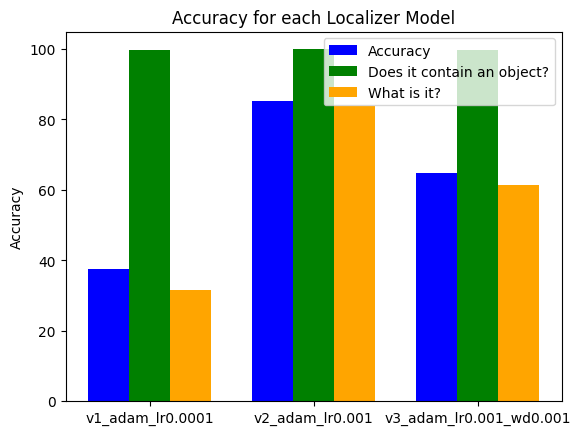

In [115]:
def plot_model_performance(models:[dict], category:str):

    # Get the data for each localizer
    localizer_names = []
    accuracy_values = []
    confidence_accuracy_values = []
    classifier_accuracy_values = []

    for name, localizer in localizers.items():
        localizer_names.append(name)
        accuracy_values.append(localizer['val.accuracy'])
        confidence_accuracy_values.append(localizer['val.accuracy_confidence'])
        classifier_accuracy_values.append(localizer['val.accuracy_classifier'])

    # Set the width of the bars
    bar_width = 0.25

    # Set the positions of the bars on the x-axis
    r1 = range(len(localizer_names))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, accuracy_values, color='blue', width=bar_width, label='Accuracy')
    plt.bar(r2, confidence_accuracy_values, color='green', width=bar_width, label='Does it contain an object?')
    plt.bar(r3, classifier_accuracy_values, color='orange', width=bar_width, label='What is it?')

    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for each {category} Model')
    plt.xticks([r + bar_width for r in range(len(localizer_names))], localizer_names)
    plt.legend()

    # Show the plot
    plt.savefig(f'assets/accuracy_{category}.png')
    plt.show()

plot_model_performance(localizers, category='Localizer')

v2_adam_lr0.001 performed best on the validation set
Score: 85.49, IoU: -1.13, Confidence: 99.9%, Classifier: 85.3%, Accuracy: 86.6%
Score: 87.49, IoU: -1.13, Confidence: 100.0%, Classifier: 87.5%, Accuracy: 88.6%


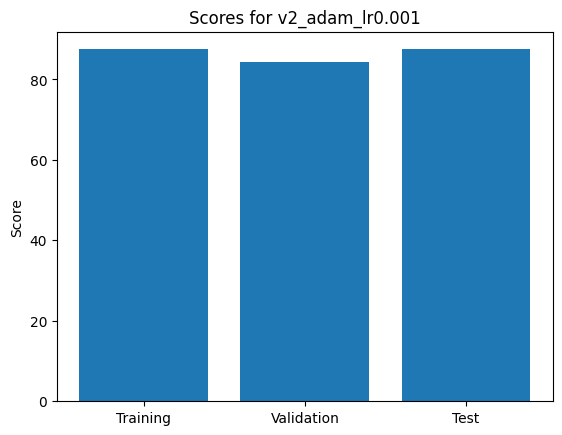

v2_adam_lr0.001: Training: 87.49, Validation: 84.21, Test: 85.49


In [78]:
# Pick model with the best score

best_localizer_name = max(localizers, key=lambda x: localizers[x]['val.score'])

print(f"{best_localizer_name} performed best on the validation set")

# Validate best model on test set
best_localizer_score_test, _, _, _, _ = test_localizer(localizers[best_localizer_name]['model'], localization_test_loader)
best_localizer_score_train, _, _, _, _ = test_localizer(localizers[best_localizer_name]['model'], localization_train_loader)
best_localizer_score_val = localizers[best_localizer_name]['val.score']

plt.bar(
    ['Training', 'Validation', 'Test'], 
    [best_localizer_score_test, best_localizer_score_val, best_localizer_score_train])

plt.title(f"Scores for {best_localizer_name}")
plt.ylabel("Score")
plt.savefig(f"assets/score_{best_localizer_name}.png")
plt.show()

print(f"{best_localizer_name}: Training: {best_localizer_score_train:.2f}, Validation: {best_localizer_score_val:.2f}, Test: {best_localizer_score_test:.2f}")


# Object detection

In [79]:
detection_train = torch.load('data/detection_train.pt')
detection_val = torch.load('data/detection_val.pt')
detection_test = torch.load('data/detection_test.pt')

detection_train_loader = torch.utils.data.DataLoader(detection_train, batch_size=BATCH_SIZE, shuffle=True)
detection_val_loader = torch.utils.data.DataLoader(detection_val, batch_size=BATCH_SIZE, shuffle=False)
detection_test_loader = torch.utils.data.DataLoader(detection_test, batch_size=BATCH_SIZE, shuffle=False)

In [80]:
class YoloDetectionNetwork(nn.Module):
    def __init__(self):
        super(YoloDetectionNetwork, self).__init__()

        # Input = (1, 48, 60)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Input = (32, 24, 30)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Input = (64, 12, 15)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            # Input = (128, 10, 13)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            # Input = (128, 8, 11)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            # Input = (128, 6, 9)
            nn.MaxPool2d((3, 3)),
            # Input = (128, 2, 3)
            nn.Conv2d(in_channels=128, out_channels=15, kernel_size=(3, 3), padding=1),
            # Output = (15, 2, 3)
        )
        

    def forward(self, x) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(-1, 2, 3, 15)
        return out

In [88]:
def train_detector(model:nn.Module, optimizer, name:str):
    
        print(f"Training: {name}")
    
        losses = []
    
        model.train()
        for epoch in range(EPOCH_COUNT):
    
            total_loss = 0.0
            total_size = 0
    
            for i, (images, labels) in enumerate(detection_train_loader):
                
                # Reformat the class labels to one_hot
                class_labels = labels[..., -1].long()
                class_labels = F.one_hot(class_labels, num_classes=10).float()
                labels = torch.cat((labels[..., :-1], class_labels), dim=-1)

                # Zero model gradients.
                optimizer.zero_grad()
    
                # Make predictions
                pred = model(images)
    
                # We calculate confidence loss for all images
                loss = F.mse_loss(pred, labels)
    
                # Calculate total loss and gradients
                loss.backward()
    
                # Update model weights
                optimizer.step()
    
                # Keep track of loss
                total_size += images.size(0)
                total_loss += loss.item()
    
            epoch_loss = total_loss / total_size
            losses.append(epoch_loss)
            torch.save(model.state_dict(), f'models/train/{name}_e{epoch}.pt')
            print(f'Epoch {epoch + 1}/{EPOCH_COUNT}, \tLoss: {epoch_loss}')
    
        torch.save(model.state_dict(), f'models/{name}.pt')
    
        # Plot the loss
        plt.plot(losses)
        plt.title(f"Loss for {name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.savefig(f"assets/loss_{name}.png")

def train_or_load_detector(model:nn.Module, optimizer, name:str):
    try:
        model.load_state_dict(torch.load(f'models/{name}.pt'))
        model.eval()
        print(f"Loaded: {name}")
    except FileNotFoundError:
        train_detector(model, optimizer, name)

In [107]:
def test_detector(model:nn.Module, data_loader:torch.utils.data.DataLoader):

    # Number of images with objects
    images_with_objects = 0

    # Accuracy of the predictions
    predict_total = 0
    predict_correct = 0

    # Number of images correctly identified as having or not having objects
    confidence_correct = 0

    # Number of correctly identified classes
    classifier_correct = 0

    # Aggregate IoU
    total_iou = 0

    # Put the model in evaluation mode
    model.eval()

    for i, (images, labels) in enumerate(data_loader):

        # Make predictions
        pred = model(images)


        # We found it easier to work with each
        # image individually
        for i in range(images.size(0)):
            
            _w = 60.0 / 3.0
            _h = 48.0 / 2.0

            # Generalization of the localization model
            for y in range(2):
                for x in range(3):

                        _pred = pred[i, y, x]
                        _true = labels[i, y, x]

                        # Does the image contain an object?
                        has_object = _true[0].item() > 0.5

                        # Does the model predict an object?
                        pred_has_object = _pred[0].item() > 0.5

                        # We have made a prediction
                        predict_total += 1

                        if has_object is False and pred_has_object is False:
                                # We have correctly predicted that the image does not contain an object
                                # The other metrics makes no sense.
                                confidence_correct += 1
                                predict_correct += 1
                                continue

                        if has_object is False:
                                # The image does not contain an object, but the model predicts that it does
                                # The other metrics makes no sense.
                                continue

                        # The image contains an object
                        images_with_objects += 1
                        
                        if pred_has_object:
                                # The image contains an object and the model predicts that it does
                                # Hurray!
                                confidence_correct += 1

                        # Calculate the labels
                        true_class_label = _true[5].long()
                        pred_class_label = _pred[5:].long().argmax().item()

                        if true_class_label == pred_class_label:
                                # The classifier correctly identified the object
                                classifier_correct += 1
                                predict_correct += 1

                        # Calculate the IoU
                        total_iou += intersect_over_union(_pred[1:5], _true[1:5]).item()

    confidence_accuracy = confidence_correct * 100 / predict_total
    classifier_accuracy = classifier_correct * 100 / images_with_objects
    accuracy = predict_correct * 100 / predict_total

    iou = total_iou / images_with_objects

    score = accuracy + iou

    print(f"Score: {score:.2f}, IoU: {iou:.2f}, Confidence: {confidence_accuracy:.1f}%, Classifier: {classifier_accuracy:.1f}%, Accuracy: {accuracy:.1f}%")
    return score, iou, accuracy, confidence_accuracy, classifier_accuracy

In [108]:
model = YoloDetectionNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_or_load_detector(model, optimizer, 'det_v0_test_adam_lr0.001')

test_detector(model, detection_val_loader)

Loaded: det_v0_test_adam_lr0.001
Score: 89.63, IoU: -1.95, Confidence: 98.5%, Classifier: 63.1%, Accuracy: 91.6%


(89.63147489117505,
 -1.9537402531907582,
 91.5852151443658,
 98.52263790585327,
 63.05220883534137)

In [111]:
# Define models

detector_v1 = 'det1_adam_lr0.0001'
detector_v2 = 'det2_adam_lr0.001'
detector_v3 = 'det3_adam_lr0.001_wd0.001'

detectors = dict()
detectors[detector_v1] = dict()
detectors[detector_v1]['model'] = YoloDetectionNetwork()
detectors[detector_v1]['optimizer'] = torch.optim.Adam(detectors[detector_v1]['model'].parameters(), lr=0.0001)

detectors[detector_v2] = dict()
detectors[detector_v2]['model'] = YoloDetectionNetwork()
detectors[detector_v2]['optimizer'] = torch.optim.Adam(detectors[detector_v2]['model'].parameters(), lr=0.001)

detectors[detector_v3] = dict()
detectors[detector_v3]['model'] = YoloDetectionNetwork()
detectors[detector_v3]['optimizer'] = torch.optim.Adam(detectors[detector_v3]['model'].parameters(), lr=0.001, weight_decay=0.001)

# Load or train, then validate models

for name, detector in detectors.items():
    train_or_load_detector(detector['model'], detector['optimizer'], name)
    score, iou, accuracy, accuracy_confidence, accuracy_classifier = test_detector(detector['model'], detection_val_loader)
    detector['val.score'] = score
    detector['val.iou'] = iou
    detector['val.accuracy'] = accuracy
    detector['val.accuracy_confidence'] = accuracy_confidence
    detector['val.accuracy_classifier'] = accuracy_classifier

Loaded: det1_adam_lr0.0001
Score: 86.96, IoU: -1.68, Confidence: 97.9%, Classifier: 49.8%, Accuracy: 88.6%
Loaded: det2_adam_lr0.001
Score: 89.63, IoU: -1.95, Confidence: 98.5%, Classifier: 63.1%, Accuracy: 91.6%
Loaded: det3_adam_lr0.001_wd0.001
Score: 86.33, IoU: -1.48, Confidence: 96.9%, Classifier: 46.9%, Accuracy: 87.8%


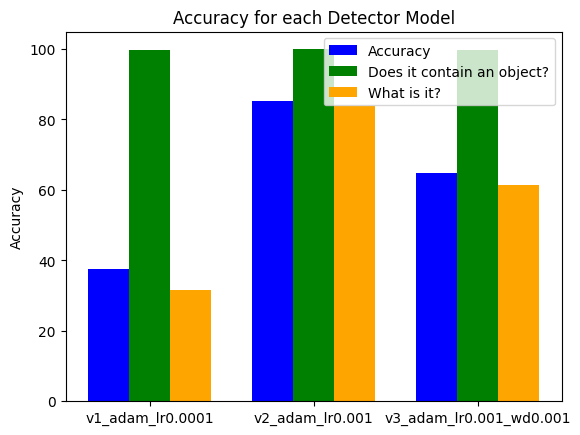

In [116]:
plot_model_performance(detectors, category='Detector')

det2_adam_lr0.001 performed best on the validation set
Score: 90.07, IoU: -1.59, Confidence: 98.4%, Classifier: 63.9%, Accuracy: 91.7%
Score: 90.03, IoU: -1.67, Confidence: 98.6%, Classifier: 63.9%, Accuracy: 91.7%


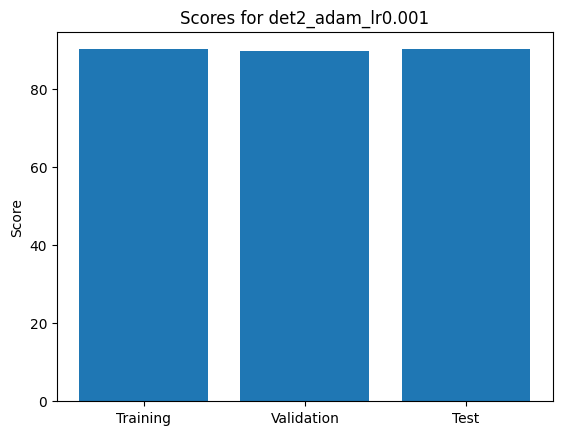

det2_adam_lr0.001: Training: 90.03, Validation: 89.63, Test: 90.07


In [118]:
# Pick model with the best score

best_detector_name = max(detectors, key=lambda x: detectors[x]['val.score'])

print(f"{best_detector_name} performed best on the validation set")

# Validate best model on test set
best_detector_score_test, _, _, _, _ = test_detector(detectors[best_detector_name]['model'], detection_test_loader)
best_detector_score_train, _, _, _, _ = test_detector(detectors[best_detector_name]['model'], detection_train_loader)
best_detector_score_val = detectors[best_detector_name]['val.score']

plt.bar(
    ['Training', 'Validation', 'Test'], 
    [best_detector_score_test, best_detector_score_val, best_detector_score_train])

plt.title(f"Scores for {best_detector_name}")
plt.ylabel("Score")
plt.savefig(f"assets/score_{best_detector_name}.png")
plt.show()

print(f"{best_detector_name}: Training: {best_detector_score_train:.2f}, Validation: {best_detector_score_val:.2f}, Test: {best_detector_score_test:.2f}")